In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score,roc_curve,RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,LeaveOneOut
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

(a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/ APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test
set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
trainset = pd.read_csv('../Data/aps_failure_training_set.csv',skiprows=20)
testset = pd.read_csv('../Data/aps_failure_test_set.csv',skiprows=20)
train_y = trainset['class']
trainset = trainset.drop('class',axis=1)
data_col = trainset.columns
test_y = testset['class']
testset = testset.drop('class',axis=1)

(b) Data Preparation
This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

**Ans:**
1. Imputation:

a. from another randomly selected observation

b. statistics such as mean, median, or mode.

c. estimated by model based on other features.(KNN)

2. Use models that support missing values

I imputed the feature with less than 10000 missing data with the feature mean. For rest of those features missing more than 10000 data, I imputed them with knn model.

In [3]:
missing_count = (trainset=='na').sum(axis=0).sort_values(ascending=False)
missing_count[missing_count<10000].index

Index(['cm_000', 'cl_000', 'ed_000', 'ak_000', 'ca_000', 'dm_000', 'dh_000',
       'dg_000', 'df_000', 'dl_000',
       ...
       'bj_000', 'ao_000', 'aq_000', 'bi_000', 'by_000', 'cj_000', 'ci_000',
       'ck_000', 'bt_000', 'aa_000'],
      dtype='object', length=145)

In [4]:
imp = {}
for i in missing_count[missing_count<10000].index:
    imp[i] = np.mean([float(j) for j in trainset[i] if j != 'na'])
    trainset[i] = trainset[i].replace('na',imp[i])
    testset[i] = testset[i].replace('na',imp[i])

In [5]:
trainset = trainset.replace('na',np.nan)
testset = testset.replace('na',np.nan)

In [6]:
imp_knn = KNNImputer(n_neighbors=10)
imp_knn = imp_knn.fit(trainset)
trainset = imp_knn.transform(trainset)
testset = imp_knn.transform(testset)

In [7]:
trainset = pd.DataFrame(trainset,columns=data_col)
testset = pd.DataFrame(testset,columns=data_col)

In [8]:
dataset = pd.concat([trainset,testset])
data_y = pd.concat([train_y,test_y])
dataset.index=range(len(dataset))
data_y.index = range(len(data_y))

ii. For each of the 170 features, calculate the coefficient of variation CV = ms , where s is sample standard deviation and m is sample mean.

In [10]:
agg = dataset.agg(['std','mean'],axis=0)
cv = (agg.iloc[0]/agg.iloc[1]).sort_values(ascending=False)
cv

cf_000    231.801755
co_000    231.133026
ad_000    231.020404
cs_009    193.045035
dj_000    120.084900
             ...    
bo_000      0.521249
bq_000      0.512430
br_000      0.501362
bp_000      0.491295
cd_000      0.000000
Length: 170, dtype: float64

iii. Plot a correlation matrix for your features using pandas or any other tool.

          aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.052361 -0.011690 -0.000940  0.025819  0.036032  0.011681   
ab_000  0.052361  1.000000 -0.074647  0.000175  0.017335  0.030348  0.002848   
ac_000 -0.011690 -0.074647  1.000000 -0.001987 -0.004769 -0.010612  0.015530   
ad_000 -0.000940  0.000175 -0.001987  1.000000 -0.000193 -0.000236 -0.000044   
ae_000  0.025819  0.017335 -0.004769 -0.000193  1.000000  0.829986 -0.000440   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.356969  0.037789 -0.018666 -0.000833  0.036649  0.046529  0.007631   
ee_008  0.259669  0.059187  0.010423 -0.001265 -0.008379 -0.010821  0.000067   
ee_009  0.133764  0.040210  0.017288 -0.000742 -0.006947 -0.008531 -0.001103   
ef_000  0.006754  0.034596 -0.006192 -0.000090  0.063587  0.093474 -0.000075   
eg_000  0.010299  0.055223  0.015826 -0.000094  0.030854  0.044368  0.000156   

          ag_001    ag_002    ag_003  .

<function matplotlib.pyplot.show(close=None, block=None)>

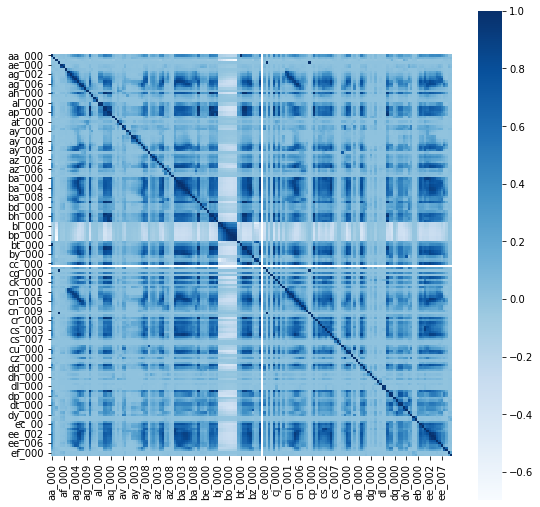

In [11]:
corr_matrix = dataset.corr()
print(corr_matrix)
plt.subplots(figsize=(9,9))
sns.heatmap(corr_matrix, vmax=1, square=True, cmap='Blues')
plt.show

iv. Pick ⌊$\sqrt{170}$⌋ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. 
Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [12]:
data_cv = dataset[cv[:int(np.floor(np.sqrt(170)))].index]

In [13]:
print("The 13 features with the highest CV are :", list(data_cv.columns))

The 13 features with the highest CV are : ['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'df_000', 'as_000', 'dh_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009']


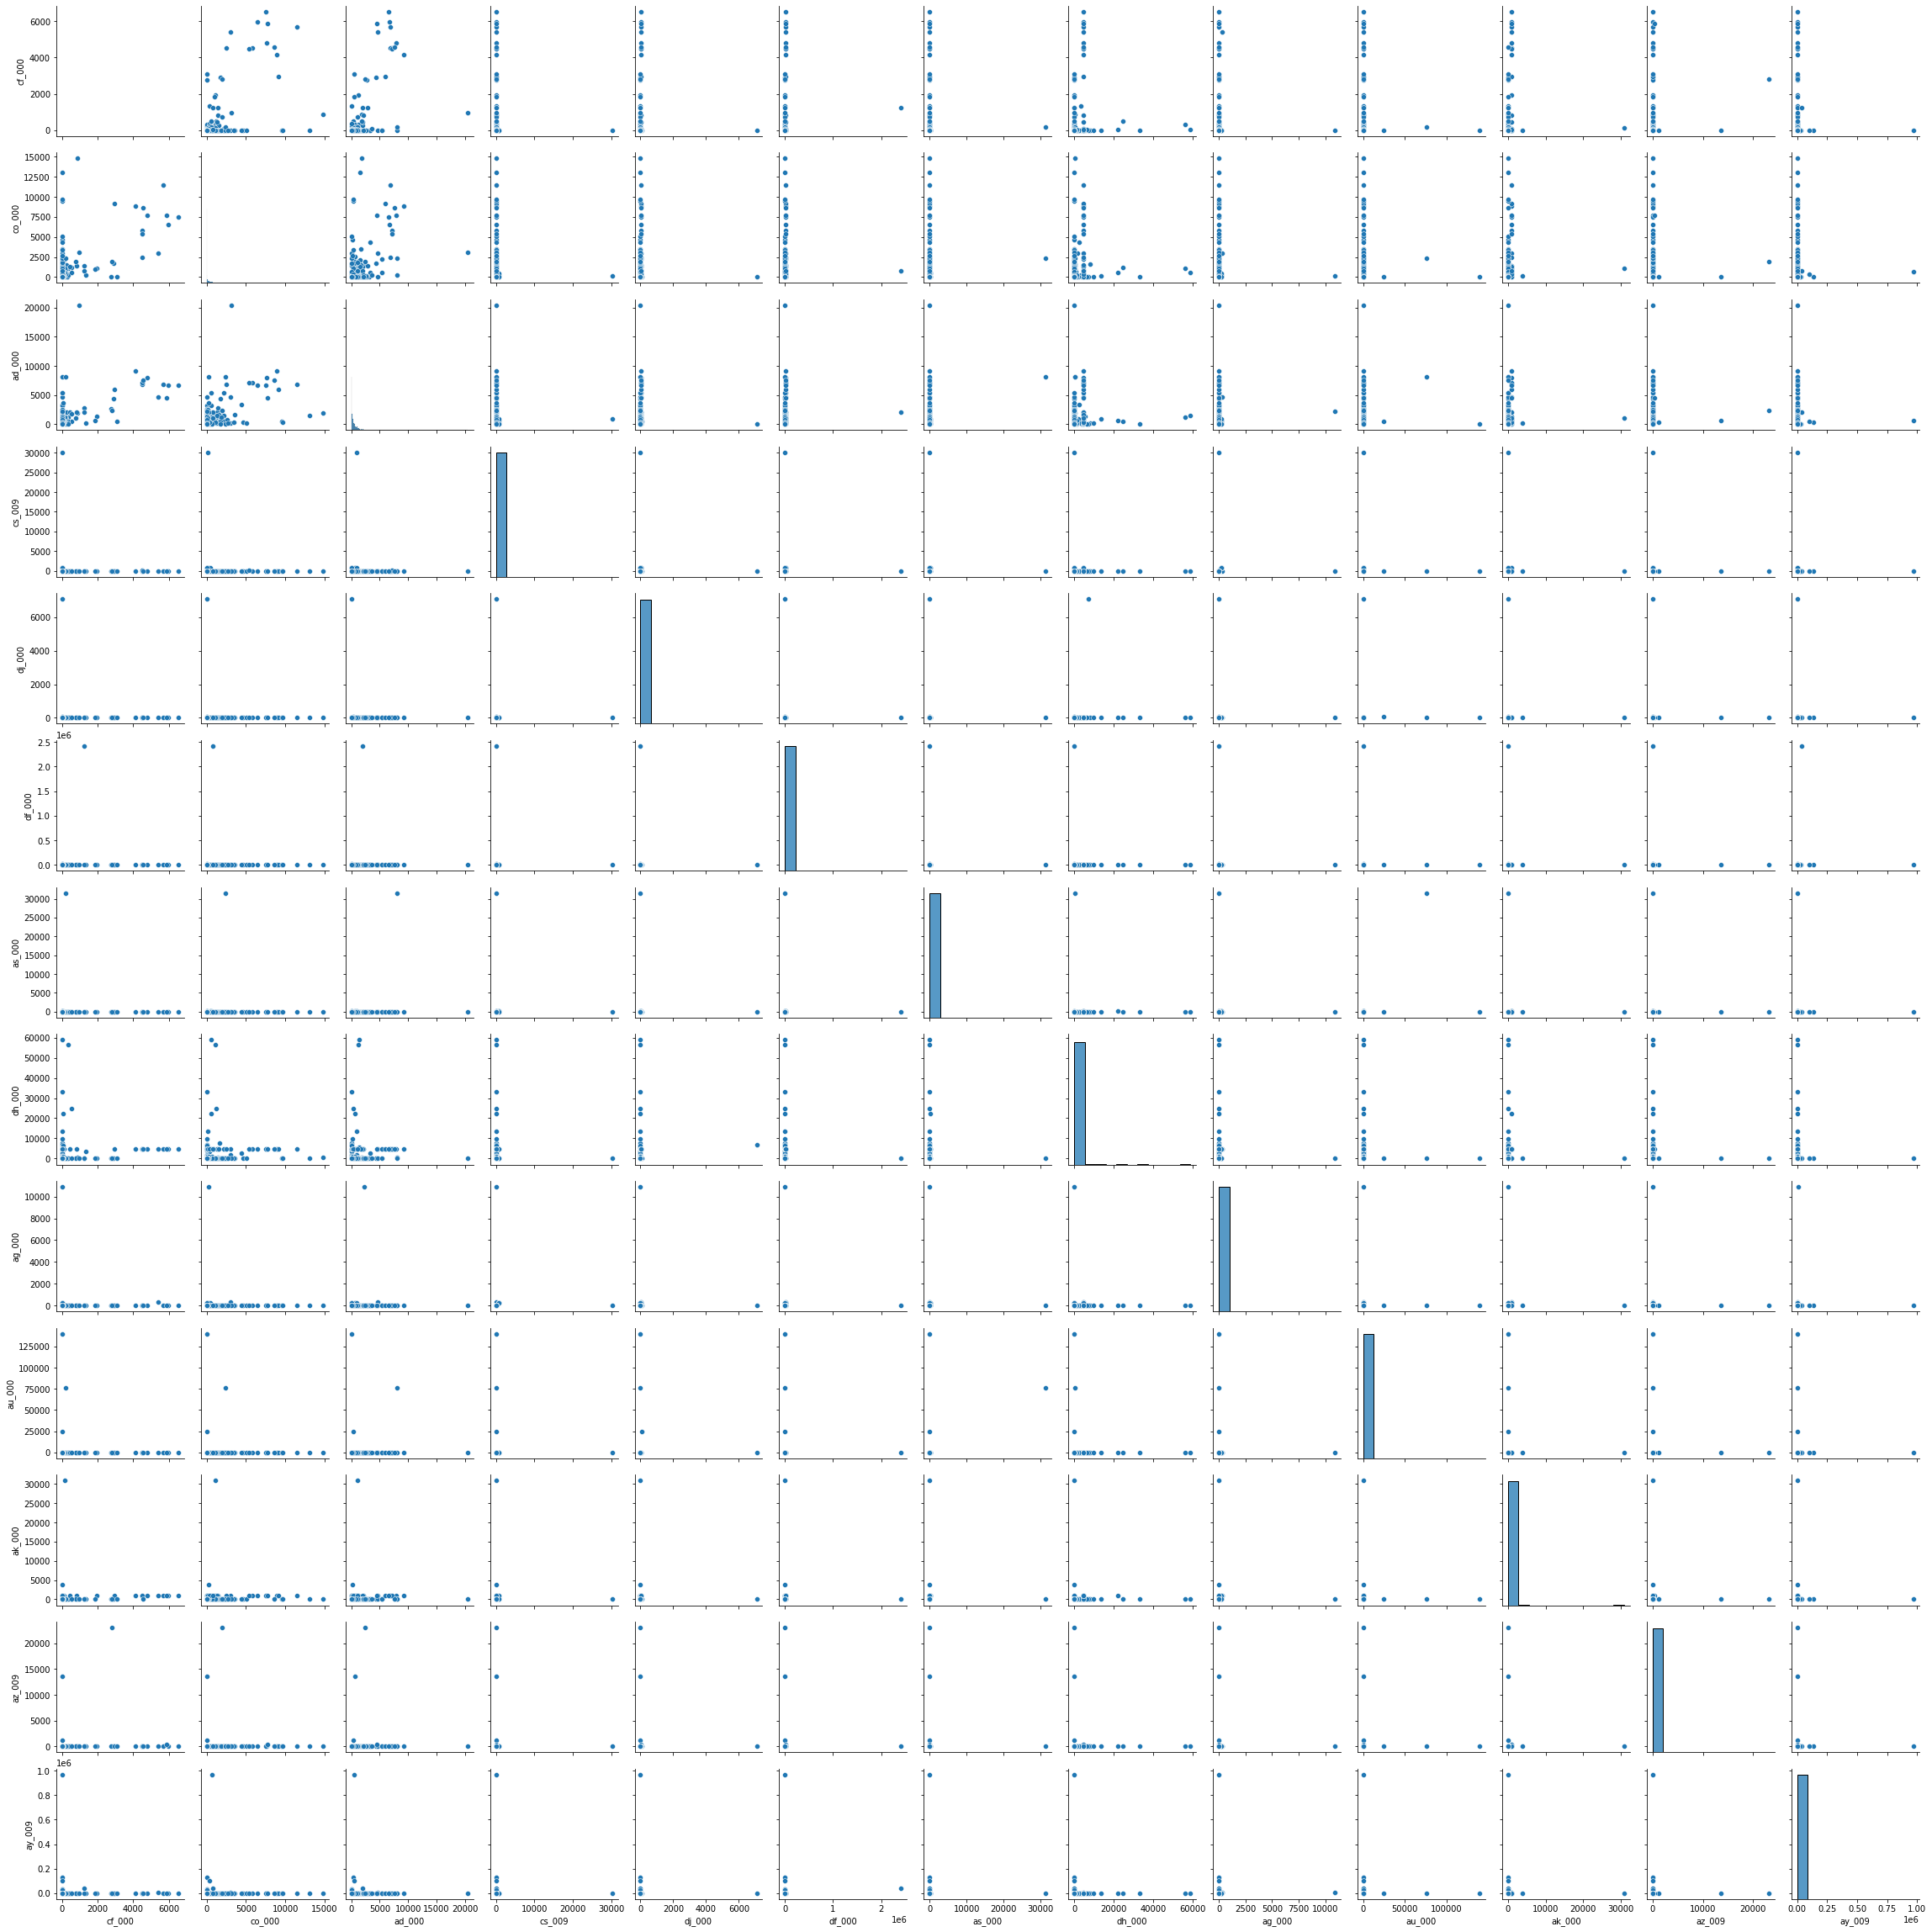

In [14]:
data_cv.loc[:,'class'] = data_y
data_cv_sample = data_cv.sample(frac=0.01)
sns.pairplot(data_cv_sample)

I think 'cf_000', 'co_000', 'ad_000' will be relevant significant because they have higher variance.

[Text(0, 0, 'cf_000'),
 Text(1, 0, 'co_000'),
 Text(2, 0, 'ad_000'),
 Text(3, 0, 'cs_009'),
 Text(4, 0, 'dj_000'),
 Text(5, 0, 'df_000'),
 Text(6, 0, 'as_000'),
 Text(7, 0, 'dh_000'),
 Text(8, 0, 'ag_000'),
 Text(9, 0, 'au_000'),
 Text(10, 0, 'ak_000'),
 Text(11, 0, 'az_009'),
 Text(12, 0, 'ay_009')]

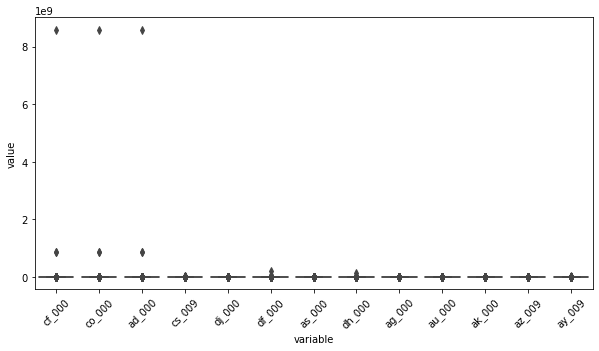

In [15]:
plt.figure(figsize=[10,5])
data_cv = data_cv.drop("class", axis=1)
ax = sns.boxplot(data = data_cv.melt(),x='variable',y='value')
ax.set_xticklabels(labels=data_cv.columns,rotation=45,fontsize=10)

v. Determine the number of positive and negative data. Is this data set imbalanced?

In [16]:
train_y.value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

Since there are 59000 negative data but only 1000 positive data, we can say that the dataset is imblanced.

In [17]:
def metrics(y_train,train_pred,y_test,test_pred):
    fpr, tpr, threshold = roc_curve(y_train,train_pred)
    cm = confusion_matrix(y_train,train_pred)
    print("train set's confusion matrix:",'\n',cm)
    print("trainset's misclassification:",cm[0][1]+cm[1][0])
    auc_score = roc_auc_score(y_train,train_pred)
    RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score).plot()
    plt.title('the ROC curve and AUC of training set')
    
    fpr, tpr, threshold = roc_curve(y_test,test_pred)
    cm = confusion_matrix(y_test,test_pred)
    print("test set's confusion matrix:",'\n',cm)
    print("test set's misclassification:",cm[0][1]+cm[1][0])
    auc_score = roc_auc_score(y_test,test_pred)
    RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score).plot()
    plt.title('the ROC curve and AUC of test set')


(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [18]:
train_y = train_y.replace('pos',1)
train_y = train_y.replace('neg',0)
test_y = test_y.replace('pos',1)
test_y = test_y.replace('neg',0)

In [33]:
rf = RandomForestClassifier(oob_score=True, n_jobs=8)
rf = rf.fit(trainset,train_y)
pred_train = rf.predict(trainset)
pred_test = rf.predict(testset)

train set's confusion matrix: 
 [[59000     0]
 [    1   999]]
trainset's misclassification: 1
test set's confusion matrix: 
 [[15607    18]
 [  112   263]]
test set's misclassification: 130


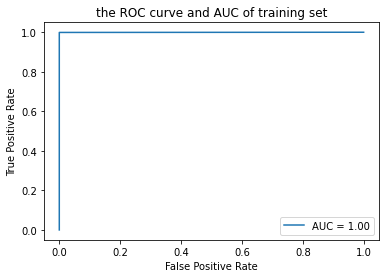

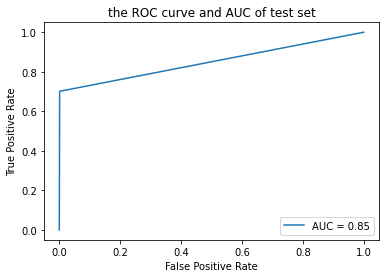

In [34]:
metrics(train_y,pred_train,test_y,pred_test)

In [35]:
print('The out of bag error is:',1-round(rf.oob_score_,4))

The out of bag error is: 0.006099999999999994


In [36]:
print('The test set error is:',1-round(accuracy_score(test_y,pred_test),4))

The test set error is: 0.008099999999999996


(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

By setting the random forest model parameter 'class_weight' = 'balanced', the data used to train the model will be automatically weighted by the reciprocal of their class frequencies. 

In [37]:
rf = RandomForestClassifier(oob_score=True,class_weight='balanced', n_jobs=8)
rf = rf.fit(trainset,train_y)
pred_train = rf.predict(trainset)
pred_test = rf.predict(testset)

train set's confusion matrix: 
 [[59000     0]
 [    0  1000]]
trainset's misclassification: 0
test set's confusion matrix: 
 [[15609    16]
 [  159   216]]
test set's misclassification: 175


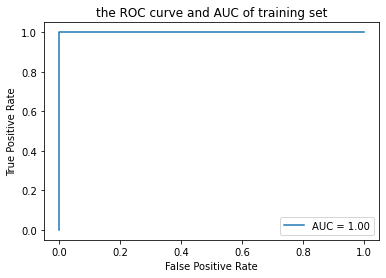

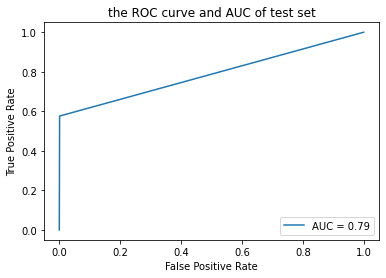

In [38]:
metrics(train_y,pred_train,test_y,pred_test)

In [39]:
print('The out of bag error is:',1-round(rf.oob_score_,4))

The out of bag error is: 0.007800000000000029


In [40]:
print('The test set error is:',1-round(accuracy_score(test_y,pred_test),4))

The test set error is: 0.01090000000000002


After balancing, the training error decreases but the testing error increases(without compensation:0.008, with compensation: 0.012). I think that is because the testset is also imbalance. The distribution of test set are more similar with the original trainset distribution.

In [41]:
test_y.value_counts()

0    15625
1      375
Name: class, dtype: int64

(e) You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [42]:
def xgboostcv(n_folds):
    l1_score = {}
    
    for a in range(0,-10,-2):
        tmp = []
        kf = KFold(n_splits=n_folds,shuffle=True,random_state=10)
        for train_index, test_index in kf.split(trainset):
            cv_train, cv_test = np.array(trainset)[train_index], np.array(trainset)[test_index]
            cvy_train, cvy_test = np.array(train_y)[train_index], np.array(train_y)[test_index]
            xgb = XGBClassifier(reg_alpha=np.exp(a),verbosity = 0,silent=True, nthread=8).fit(cv_train,cvy_train)
            pred_test = xgb.predict(cv_test)
            tmp.append(accuracy_score(cvy_test,pred_test))
        l1_score[a] = np.mean(tmp)
    best_l1 = sorted(l1_score.items(),key=lambda x:x[1],reverse=True)[0]
    print('alpha:',round(np.exp(best_l1[0]),4),'score:',round(best_l1[1],4))
    xgb = XGBClassifier(reg_alpha=np.exp(best_l1[0]),verbosity = 0,silent=True, nthread=8).fit(np.array(trainset),np.array(train_y))
    print('train error:',1-round(accuracy_score(np.array(train_y),xgb.predict(np.array(trainset))),4))
    print('test error:',1-round(accuracy_score(np.array(test_y),xgb.predict(np.array(testset))),4))
    metrics(np.array(train_y),xgb.predict(np.array(trainset)),np.array(test_y),xgb.predict(np.array(testset)))
        

alpha: 0.1353 score: 0.9948
train error: 0.0
test error: 0.006399999999999961
train set's confusion matrix: 
 [[59000     0]
 [    1   999]]
trainset's misclassification: 1
test set's confusion matrix: 
 [[15610    15]
 [   87   288]]
test set's misclassification: 102


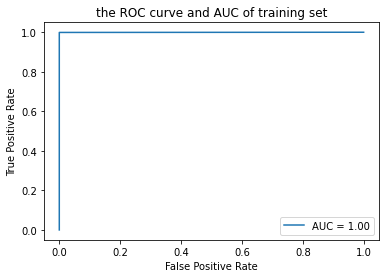

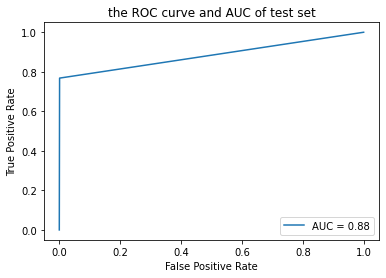

In [46]:
xgboostcv(5)

(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [47]:
def smotecv(n_folds):
    l1_score = {}
    
    for a in range(0,-10,-2):
        tmp = []
        kf = KFold(n_splits=n_folds,shuffle=True,random_state=10)
        for train_index, test_index in kf.split(trainset):
            cv_train, cv_test = np.array(trainset)[train_index], np.array(trainset)[test_index]
            cvy_train, cvy_test = np.array(train_y)[train_index], np.array(train_y)[test_index]
            sm = SMOTE(random_state=10)
            cv_train,cvy_train = sm.fit_resample(cv_train,cvy_train)
            xgb = XGBClassifier(reg_alpha=np.exp(a),verbosity = 0,silent=True).fit(cv_train,cvy_train)
            pred_test = xgb.predict(cv_test)
            tmp.append(accuracy_score(cvy_test,pred_test))
        l1_score[a] = np.mean(tmp)
    best_l1 = sorted(l1_score.items(),key=lambda x:x[1],reverse=True)[0]
    print('alpha:',round(np.exp(best_l1[0]),4),'score:',round(best_l1[1],4))
    sm = SMOTE(random_state=10)
    smote_train,smote_ytrain = sm.fit_resample(trainset,train_y)
    xgb = XGBClassifier(reg_alpha=np.exp(best_l1[0]),verbosity = 0,silent=True).fit(np.array(smote_train),np.array(smote_ytrain))
    print('train error:',1-round(accuracy_score(np.array(smote_ytrain),xgb.predict(np.array(smote_train))),4))
    print('test error:',1-round(accuracy_score(np.array(test_y),xgb.predict(np.array(testset))),4))
    metrics(np.array(smote_ytrain),xgb.predict(np.array(smote_train)),np.array(test_y),xgb.predict(np.array(testset)))

alpha: 0.0003 score: 0.9934
train error: 0.0
test error: 0.007099999999999995
train set's confusion matrix: 
 [[59000     0]
 [    1 58999]]
trainset's misclassification: 1
test set's confusion matrix: 
 [[15574    51]
 [   63   312]]
test set's misclassification: 114


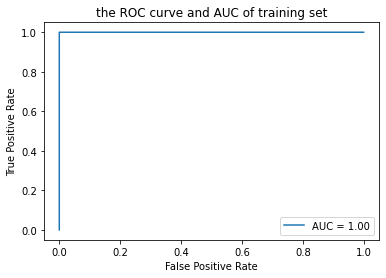

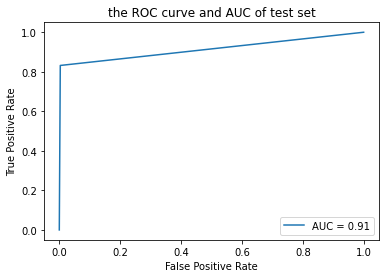

In [48]:
smotecv(5)

Just like the result of random forest model, after compensation, the test set error increases(with smote:0.007, without smote:0.006).Also the AUC of the model increase(with smote:0.91,without smote:0.88). That is the model with smote can better classify the data with appropriate threshold.

**ISLR**

![1](1.jpeg)

![2](2.jpeg)

![3](3.jpeg)

![4](4.jpeg)